<a href="https://colab.research.google.com/github/kerryback/2022-638-binder/blob/main/9-targets-and-industries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymssql


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sqlalchemy import create_engine
import pymssql
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

import matplotlib.pyplot as plt

In [3]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" # paste password between quote marks
database = "ghz"

string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

In [4]:
data = pd.read_sql(
    """
    select ticker, date, ret, roeq, mom12m, siccd
    from data
    where date>='2000-01'
    order by date, ticker
    """, 
    conn
)
data = data.dropna()

ff49 = pd.read_excel("files/ff49.xlsx", index_col=0)
def industry(sic):
  try:
    return ff49[(ff49.lower<=sic)&(sic<=ff49.upper)].index[0]
  except:
    return "Almost Nothing"
    
data["industry"] = data.siccd.map(industry)


In [5]:
factors = pdr("F-F_Research_Data_Factors", "famafrench", start=2000)[0] / 100
factors = factors.reset_index()
factors["Date"] = factors["Date"].astype(str)

data = data.merge(factors, left_on="date", right_on="Date")
data["retx"] = data["ret"] - data["RF"] - data["Mkt-RF"]

In [6]:
transform1 = QuantileTransformer(
    output_distribution="normal"
)

transform2 = QuantileTransformer(
    output_distribution="normal"
)

transform3 = QuantileTransformer(
    output_distribution="normal"
)

poly = PolynomialFeatures(degree=2)

model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(random_state=0, max_depth=4),
    transformer=transform3
)

pipe = make_pipeline(
  transform1,
  poly,
  transform2,
  model
)

In [7]:
df = None
dates = data.date.unique()
train_dates = ["2005-01", "2010-01", "2015-01"]
end_months = ["2009-12", "2014-12", "2019-01"]
for start, end in zip(train_dates, end_months):
    past = data[data.date<start]
    X = past[["roeq", "mom12m"]]
    y = past["retx"]
    pipe.fit(X, y)
    predict_dates = [d for d in dates if d>=start and d<=end]
    for d in predict_dates:
        present = data[data.date==d]
        X = present[["roeq", "mom12m"]]
        out = pd.DataFrame(dtype=float, columns=["date", "ticker", "predict", "ret"])
        out["ticker"] = present.ticker
        out["predict"] = pipe.predict(X)
        out["date"] = d
        out["ret"] = present.ret 
        out["industry"] = present.industry
        df = pd.concat((df, out))
        

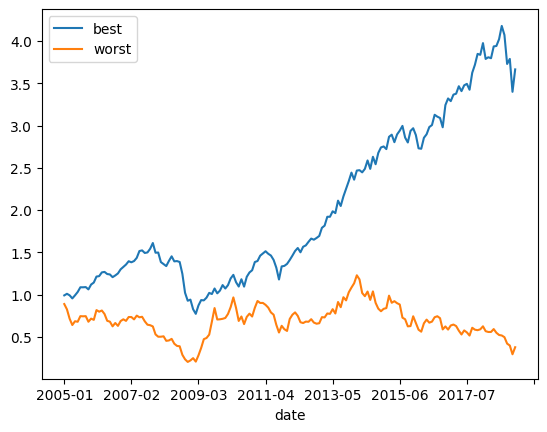

In [8]:
df["rnk"] = df.groupby("date").predict.rank(method="first", ascending=False)
best = df[df.rnk<=100]

df["rnk"] = df.groupby("date").predict.rank(method="first")
worst = df[df.rnk<100]

best_rets = best.groupby("date").ret.mean()
worst_rets = worst.groupby("date").ret.mean()

(1+best_rets).cumprod().plot(label="best")
(1+worst_rets).cumprod().plot(label="worst")
plt.legend()


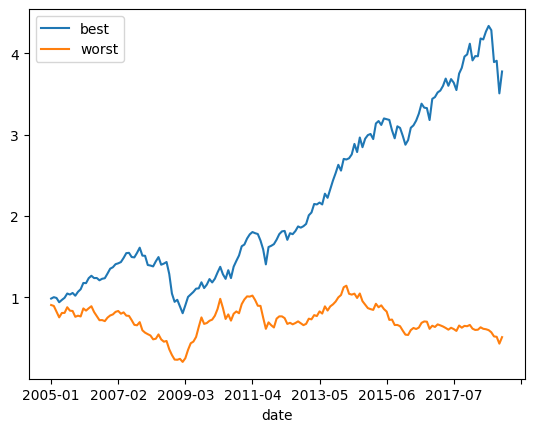

In [9]:
df["rnk"] = df.groupby(["date", "industry"]).predict.rank(method="first", ascending=False)
best = df[df.rnk<=2]

df["rnk"] = df.groupby(["date", "industry"]).predict.rank(method="first")
worst = df[df.rnk<=2]

best_rets = best.groupby("date").ret.mean()
worst_rets = worst.groupby("date").ret.mean()

(1+best_rets).cumprod().plot(label="best")
(1+worst_rets).cumprod().plot(label="worst")
plt.legend()
